In [1]:
from keras import backend as K

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras

In [4]:
model = Sequential([
    Dense(100, input_shape=(2,), activation='relu'),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(2, activation='softmax'),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

train_data = np.array([
    [1, 1],
    [1, 0],
    [0, 1],
    [0, 0]
])

# X AND Y
train_labels = keras.utils.to_categorical(np.array([
    1,
    0,
    0,
    1
]), num_classes=2)

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 20,702
Trainable params: 20,702
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(train_data, train_labels, epochs=10, verbose=False)
model.evaluate(train_data, train_labels)

4/4 [==============================] - 0s 60ms/step


[0.6121513247489929, 1.0]

In [46]:
model.predict(train_data)

array([[0.27911696, 0.720883  ],
       [0.70333445, 0.29666552],
       [0.7144378 , 0.28556216],
       [0.49622473, 0.50377524]], dtype=float32)

In [3]:
import requests
import datetime
import pytz
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [6]:
root_uri_trade_api = 'https://indodax.com/api'
root_uri_chart_api = 'https://indodax.com/tradingview/history'
#?symbol=BTCIDR&resolution=15&from=1546489788&to=1547785848'
chart_currency = 'BTCIDR'
period = 15
time_begin = int(datetime.datetime(2019, 3, 18).timestamp())
time_end = int(datetime.datetime.now().timestamp())
chart_query = '?symbol={}&resolution={}&from={}&to={}'.format(chart_currency, period, time_begin, time_end)

r = requests.get(root_uri_chart_api + chart_query)

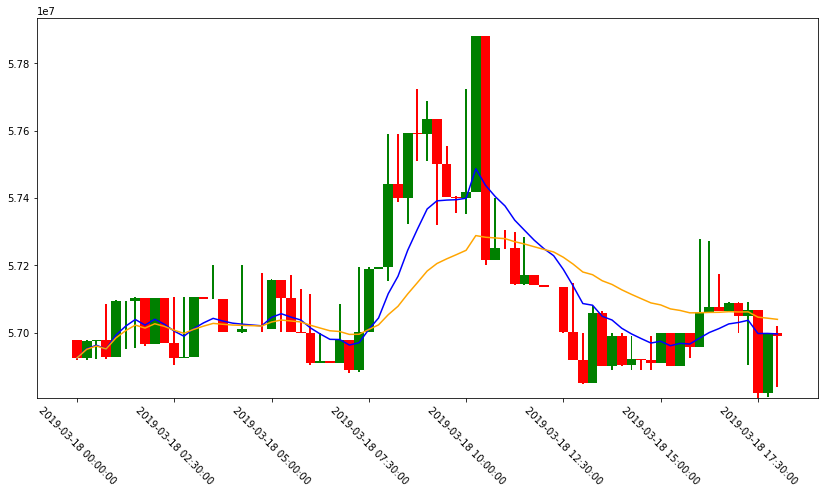

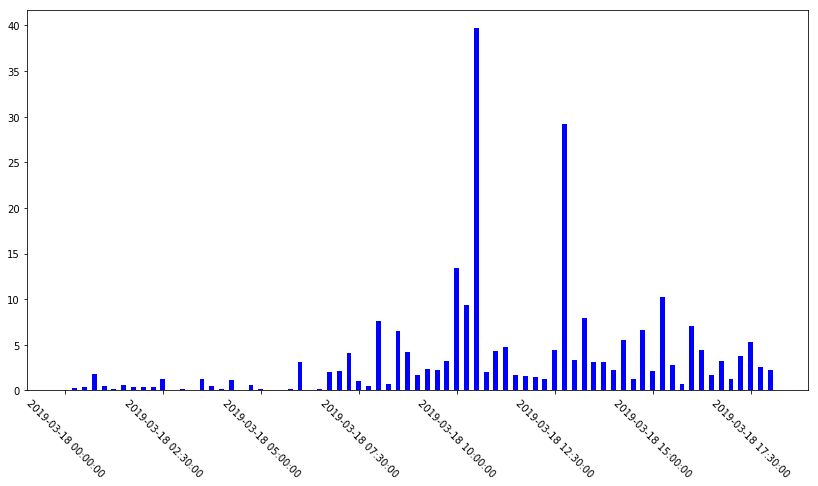

In [7]:
price = pd.DataFrame({
    'open': r.json()['o'],
    'close': r.json()['c'],
    'high': r.json()['h'],
    'low': r.json()['l'],
    'volume': r.json()['v']
# }, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)).strftime('%d/%m %H.%M'), r.json()['t'])))
}, index=list(map(lambda t: (datetime.datetime.utcfromtimestamp(t) + datetime.timedelta(hours=7)), r.json()['t'])))
candle_color = lambda o, c: 'g' if c >= o else 'r'
fig_w = len(price.open)//5
fig_h = fig_w // 2
plt.figure(figsize=(fig_w, fig_h))
plt.bar( [i for i in range(len(price.open))],
        [abs(c-o) for c,o in zip(price.close, price.open)],
        [1 for i in range(len(price.open))],
        [min(c, o) for c,o in zip(price.close, price.open)],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.bar( [i for i in range(len(price.high))],
        [h-l for h,l in zip(price.high, price.low)],
        [.2 for i in range(len(price.high))],
        [l for l in price.low],
        color=[candle_color(o, c) for c,o in zip(price.close, price.open)]
)
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=10).mean(), color='blue')
plt.plot([i for i in range(len(price.high))], price.close.ewm(span=30).mean(), color='orange')
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.figure(figsize=(fig_w, fig_h))
plt.bar([i for i in range(len(price.volume))],
        price.volume,
        .5,
        color='blue'
)
ax = plt.gca()
ax.set_xticks([i for i in range(len(price.index))][::10])
ax.set_xticklabels(price.index[::10], rotation=-45)
plt.show()


In [12]:
import backtrader as bt
import backtrader.feeds as btfeeds

In [13]:
data_feed = btfeeds.PandasData(dataname=price, openinterest=None)
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
#         self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

                
cerebro = bt.Cerebro()
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_feed)
cerebro.broker.setcash(10000000000.0)

# Print out the starting conditions
startingPortofolio = cerebro.broker.getvalue()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Run over everything
cerebro.run()

# Print out the final result
finalPortofolio = cerebro.broker.getvalue()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
print('Profit: %.2f (%.6f%%)' % (finalPortofolio - startingPortofolio, (finalPortofolio - startingPortofolio)/startingPortofolio*100))

Starting Portfolio Value: 10000000000.00
2019-01-27, BUY CREATE, 50726000.00
2019-01-27, BUY EXECUTED, 50726000.00
2019-01-27, SELL CREATE, 50759000.00
2019-01-27, SELL EXECUTED, 50759000.00
2019-01-27, BUY CREATE, 50727000.00
2019-01-27, BUY EXECUTED, 50727000.00
2019-01-27, SELL CREATE, 50572000.00
2019-01-27, SELL EXECUTED, 50572000.00
2019-01-27, BUY CREATE, 50759000.00
2019-01-27, BUY EXECUTED, 50759000.00
2019-01-27, SELL CREATE, 50710000.00
2019-01-27, SELL EXECUTED, 50710000.00
2019-01-27, BUY CREATE, 50709000.00
2019-01-27, BUY EXECUTED, 50709000.00
2019-01-27, SELL CREATE, 50626000.00
2019-01-27, SELL EXECUTED, 50626000.00
2019-01-27, BUY CREATE, 50638000.00
2019-01-27, BUY EXECUTED, 50638000.00
2019-01-27, SELL CREATE, 50648000.00
2019-01-27, SELL EXECUTED, 50648000.00
2019-01-27, BUY CREATE, 50654000.00
2019-01-27, BUY EXECUTED, 50654000.00
2019-01-27, SELL CREATE, 50699000.00
2019-01-27, SELL EXECUTED, 50699000.00
2019-01-27, BUY CREATE, 50770000.00
2019-01-27, BUY EXECUTE